<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/TrainingDataForDemosaicking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Data for Demosaicking
#### Qian, Mar 16
#### updated Mar 22



Ideas: start with demosaicking to test synthetic images. Start with single frame demosaicking and proceed to multiframe demosaicking.

* forward model is easy to model
* pixel map is not the best representation of an image

Goals: 
* model trained on the synthetic data is able to extend to real data
* model trained on local patches works on whole frames
* **model trained on mosaiced image features can predict colored image features**
* **model trained on features of poorly sampled signals can estimate features of finely sampled signals**

Reference: [Deep Joint Demosaicking and Denoising](https://groups.csail.mit.edu/graphics/demosaicnet/data/demosaic.pdf)

Notation: 
* J: ground truth colored frame with higher sampling rate (e.g. 3 x 4H x 4W)
* I: same content, mosaiced frame/features with lower sampling rate (e.g. 1 x H x W)

preprocessing step: 
$$I \rightarrow I_{comp}, J \rightarrow J_{comp}$$

single-frame pipeline: 
$$I_{comp} \rightarrow \text{network} \rightarrow \hat{J}_{comp}$$

multiframe pipeline: 
TBD

## Training with compressed features: coupled autoencoder preprocessing pipeline

As inputs and outputs have different characteristics, we can assume they do not share a common encoder, i.e., we need prepare one encoder for each to extract features. After two networks are ready, we can preprocess the data on both ends and build a demosaicing network that maps input features to output features.

a mosaiced autoencoder can be formulated as:
$$I_{comp} = f^M_{enc}(I)$$
$$\hat{I} = f^M_{dec}(I_{comp})$$

a colored autoencoder can be formulated as:
$$J_{comp} = f^C_{enc}(J)$$
$$\hat{J} = f^C_{dec}(J_{comp})$$

"M" stands for "mosaiced", "C" stands for "colored" and "comp" stands for compressed features. Two networks can share an architecture but are expected to have separate weights.

The demosaicking network can be formulated as:
$$\hat{J}_{comp} = f^D(I_{comp})$$

*Comments: my intuition is I_comp and J_comp should share same spatial dimensions but have different channels, so that the demosaicking network can avoid downsample/upsample layers.*

### diagram
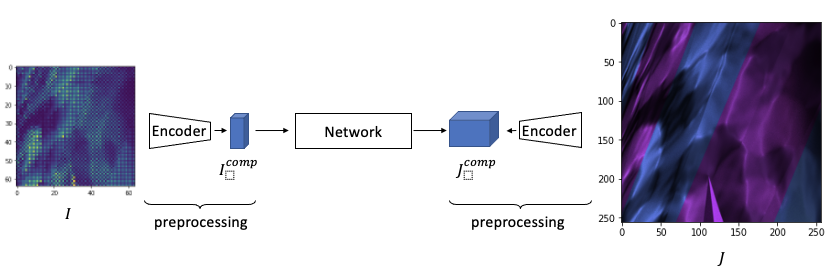

### training data
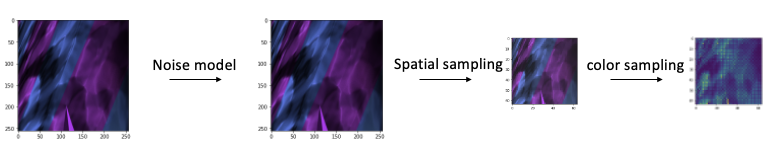

## Training Data in Blender 

In [1]:
! unzip -q drive/MyDrive/blender_256.zip

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
os.chdir("blender_256/")

In [4]:
def print_stat(narray, narray_name = "Array"):
    print(narray_name, "shape: ", narray.shape, "dtype:", narray.dtype)
    arr = narray.flatten()
    print(narray_name , "stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

In [5]:
def load_exr(path):
    img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

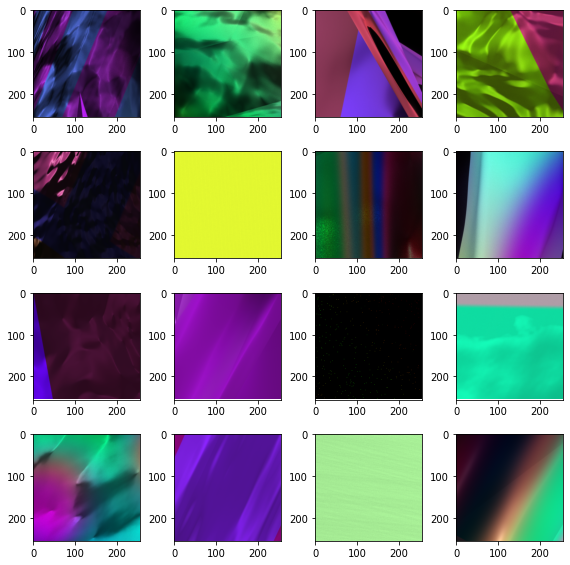

In [6]:
m, n = 4, 4
fig, ax = plt.subplots(m, n, figsize = (8, 8))
for i in range(m):
    for j in range(n):
        img = load_exr("scene{:04d}/Image/Image0001.exr".format(i * n + j))
        ax[i][j].imshow(img/img.max())
plt.tight_layout()
plt.show()

### ~~problem: not noise free in low light region~~

currently the number of samples should be quite high (81920) to approxiate noise-free frames. Each frame under this setting takes ~3 mins to render on my PC.

**Mar 17 update**: creating multiple threads on my PC produce wrong results.

In [10]:
# img = load_exr("scene{:04d}/Image/Image0001.exr".format(0))
# fig, ax = plt.subplots(1, 2, figsize = (8, 8))
# ax[0].imshow(img)
# ax[1].imshow(img/img.max())
# plt.show()
# print_stat(img)

## Forward Model

a simple pipeline to develop a mosaicked image from the field is: 

*field* -> noise model -> spatial sampling and color filter array (CFA) -> *mosaicked image*

as described in Brook's [paper](https://arxiv.org/pdf/1811.11127.pdf). [Sumner](https://www.cnba.it/contenuti/uploads/2016/03/Processing-RAW-Images-in-MATLAB-Sumner.pdf) includes "linearization" and "white balance" blocks before CFA, which can be either unnecessary for Blender outputs (as sensor response are already linearized) or can be interchangeably moved after CFA.

Some parameters and configurations are adapted from Evetar lens(25mm, F/2.4) and CMOS image sensor (Sony IMX274 4K). But some (like the amplitude factor between the light intensity and the pixel response is intractable) are set without the reference of the camera but considered along with the synthetic data properties.

---
reference: [link](https://photo.stackexchange.com/questions/72505/what-does-linearization-mean-in-raw-processing/92367), [link](https://www.rcsumner.net/raw_guide/)

### Noise Model

signal-dependent noise model, i.e., 
$y = \mathcal{N}(x, \sigma^2 = \sigma_r^2 + \sigma_s x)$, where  
- $y$: measurement
- $x$: groundtruth
- $\sigma_r$: read noise coefficient
- $\sigma_s$: shot noise coefficient


### CFA
apply Bayer filter and follow RGGB pattern.

In [21]:
import skimage.measure

class camMosaicModel:
    def __init__(self):
        ''' params that are from experiments on EVETAR camera '''
        self.sigma_r = 5.3e-4
        self.sigma_s = 8.9e-5
        self.bit_depth = 10
        self.black_level = 50
        ''' params that are NOT from experiments on EVETAR camera '''
        self.amplitude = 150

    def noise_model(self, img_gt):
        '''
        follow the noise model of signal-dependent normal distribution
        '''
        sigma_noise = np.sqrt(self.sigma_r**2 + self.sigma_s*img_gt)
        noise = np.random.randn(*img_gt.shape) * sigma_noise
        img_noisy = img_gt + noise
        return img_noisy

    def rgb2bayer(self, img):
        '''
        filter a full RGB frame to be a raw frame.
        '''
        h, w, c = img.shape
        bayer_img = np.zeros((h, w))
        bayer_img[::2, ::2] = img[::2, ::2, 0]
        bayer_img[1::2, 1::2] = img[::2, ::2, 2]
        bayer_img[::2, 1::2] = img[::2, 1::2, 1]
        bayer_img[1::2, ::2] = img[1::2, ::2, 1]
        return bayer_img

    def spatial_sampling(self, img, pix = 4):
        h, w, c = img.shape
        return skimage.measure.block_reduce(img, (pix,pix, 1), np.sum)

    
    def develop(self, img_gt):
        '''
        develop raw frame from ground truth via the noise model, quantization, CFA.
        '''
        img = self.spatial_sampling(img_gt)
        img_noisy = self.noise_model(img)
        sensor_noisy = np.clip(np.round(img_noisy * self.amplitude) + self.black_level,
                               0, 2**self.bit_depth)
        sensor_noisy_float = (sensor_noisy - self.black_level)/(2**self.bit_depth - self.black_level)
        bayer_noisy = self.rgb2bayer(sensor_noisy)
        bayer_noisy_float = self.rgb2bayer(sensor_noisy_float)
        return sensor_noisy.astype(np.uint16), sensor_noisy_float, bayer_noisy.astype(np.uint16), bayer_noisy_float

## Generate Training pairs via Mosaic Model



### ground truth frame $J$

Array shape:  (256, 256, 3) dtype: float32
Array stat: max: 0.198974609375, min: 0.0010786056518554688, mean: 0.04497993364930153, std: 0.03253072500228882
Dynamic range is 7.5 bits


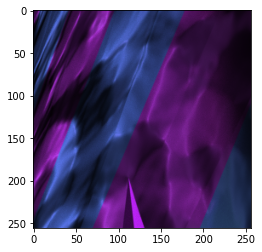

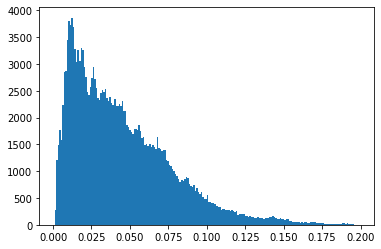

In [14]:
img = load_exr("scene0000/Image/Image0001.exr")
print_stat(img)
print("Dynamic range is {:.1f} bits".format(np.log2(img.max()/img.min())))
plt.imshow(img/img.max())
plt.show()
plt.hist(img.flatten(), bins=200)
plt.show()

display two patches

Array shape:  (64, 64, 3) dtype: float32
Array stat: max: 0.1822509765625, min: 0.0017461776733398438, mean: 0.04139573127031326, std: 0.029344972223043442
Array shape:  (64, 64, 3) dtype: float32
Array stat: max: 0.1839599609375, min: 0.004955291748046875, mean: 0.04975324869155884, std: 0.034804269671440125


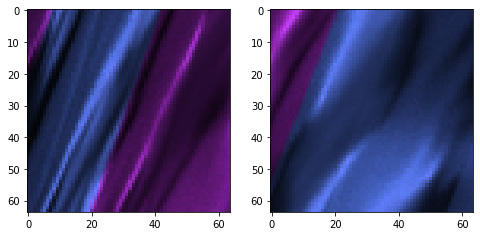

In [25]:
print_stat(img[:64,:64])
print_stat(img[-64:, :64])
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(img[:64,:64]/img[:64,:64].max())
ax[1].imshow(img[-64:, :64]/img[-64:, :64].max())
plt.show()

### raw measurement $I$

In [22]:
cam = camMosaicModel()
sensor_noisy, sensor_noisy_float, bayer_noisy, bayer_noisy_float = cam.develop(img)

camera measurement raw and distribution

Array shape:  (64, 64, 3) dtype: uint16
Array stat: max: 506, min: 54, mean: 157.964111328125, std: 76.36312858091063


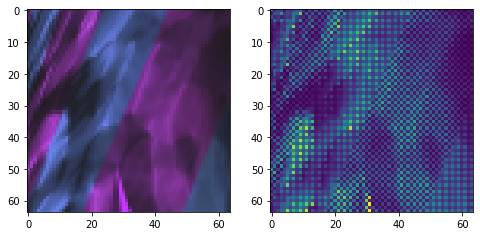

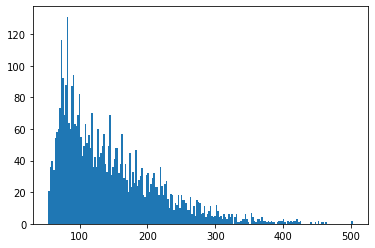

In [23]:
print_stat(sensor_noisy)
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(sensor_noisy/sensor_noisy.max())
ax[1].imshow(bayer_noisy/bayer_noisy.max())
plt.show()
plt.hist(bayer_noisy.flatten(), bins=200)
plt.show()

same areas after applying camera model

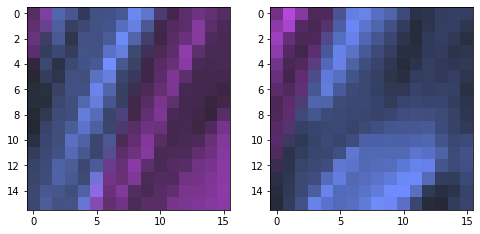

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (8, 8))
ax[0].imshow(sensor_noisy[:16,:16]/sensor_noisy[:16,:16].max())
ax[1].imshow(sensor_noisy[-16:, :16]/sensor_noisy[-16:, :16].max())
plt.show()

## Autoencoder

In [1]:
# ! wget -q http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
# ! wget -q http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

In [2]:
# ! unzip -q DIV2K_train_HR.zip
# ! unzip -q DIV2K_valid_HR.zip

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride = stride, padding=1, bias=True)

def deconv4x4(in_planes, out_planes, stride=2):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=stride, padding = 1, bias=True)

class colorAutoEncoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(colorAutoEncoder, self).__init__()
        ''' encoder'''
        self.conv1 = conv3x3(in_planes, 16, 2)
        self.conv2 = conv3x3(16, 32, 2)
        self.conv3 = conv3x3(32, feature_planes, 2)

        '''decoder'''
        self.deconv1 = deconv4x4(feature_planes, 32)
        self.deconv2 = deconv4x4(32, 16)
        self.deconv3 = deconv4x4(16, 8)
        self.conv4 = conv3x3(8, in_planes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = self.conv4(x)
        return x

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
in_planes = 3
feature_planes = 64
model = colorAutoEncoder(in_planes, feature_planes).to(device)

In [8]:
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

print_model_params(model)

#total params: 66867 | #trainable params: 66867


In [9]:
print("compression ratio -- {:.2f} : 1".format((8 * 8 * in_planes)/feature_planes))

compression ratio -- 3.00 : 1


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img, unnormalize = True):
    if unnormalize:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

### train on DIV2K

In [11]:
import os
import cv2
from PIL import Image

class Div2kDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True, transform = None):
        self.root = root
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return 800
        else:
            return 100
    
    def __getitem__(self, index):
        if self.train:
            X = Image.open(os.path.join(self.root, "DIV2K_train_HR", "{:04d}.png".format(index + 1)))
        else:
            X = Image.open(os.path.join(self.root, "DIV2K_valid_HR", "{:04d}.png".format(index + 801)))
        X = self.transform(X)
        return X

In [12]:
transform = transforms.Compose(
    [transforms.RandomCrop(32),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = Div2kDataset(root="/content", train=True, transform=transform) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = Div2kDataset(root="/content", train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

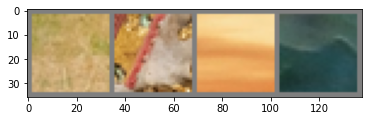

In [13]:
dataiter = iter(trainloader)
images = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [14]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:
            print('epoch %d -- %d -- loss: %.3f' %
                        (epoch + 1, i, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

epoch 1 -- 19 -- loss: 0.179
epoch 1 -- 39 -- loss: 0.101
epoch 1 -- 59 -- loss: 0.092
epoch 1 -- 79 -- loss: 0.086
epoch 1 -- 99 -- loss: 0.085
epoch 1 -- 119 -- loss: 0.071
epoch 1 -- 139 -- loss: 0.058
epoch 1 -- 159 -- loss: 0.074
epoch 1 -- 179 -- loss: 0.059
epoch 1 -- 199 -- loss: 0.050
epoch 2 -- 19 -- loss: 0.068
epoch 2 -- 39 -- loss: 0.061
epoch 2 -- 59 -- loss: 0.065
epoch 2 -- 79 -- loss: 0.056
epoch 2 -- 99 -- loss: 0.055
epoch 2 -- 119 -- loss: 0.059
epoch 2 -- 139 -- loss: 0.055
epoch 2 -- 159 -- loss: 0.073
epoch 2 -- 179 -- loss: 0.056
epoch 2 -- 199 -- loss: 0.071
epoch 3 -- 19 -- loss: 0.058
epoch 3 -- 39 -- loss: 0.053
epoch 3 -- 59 -- loss: 0.060
epoch 3 -- 79 -- loss: 0.070
epoch 3 -- 99 -- loss: 0.051
epoch 3 -- 119 -- loss: 0.063
epoch 3 -- 139 -- loss: 0.052
epoch 3 -- 159 -- loss: 0.046
epoch 3 -- 179 -- loss: 0.046
epoch 3 -- 199 -- loss: 0.051
epoch 4 -- 19 -- loss: 0.044
epoch 4 -- 39 -- loss: 0.051
epoch 4 -- 59 -- loss: 0.038
epoch 4 -- 79 -- loss: 0.063

test

In [11]:
with torch.no_grad():
    running_loss = 0.0
    running_psnr = 0.0
    total = 0
    for data in testloader:
        images = data
        images = images.to(device)
        outputs = model(images).detach()
        total += 1
        running_loss += torch.mean((outputs - images)**2)
        running_psnr += 10 * torch.log10(4/torch.mean((outputs - images)**2)) #unnormalize
print('test loss: %.3f -- test psnr: %.2f' %
                  (running_loss / total, running_psnr/total))

test loss: 0.023 -- test psnr: 23.00


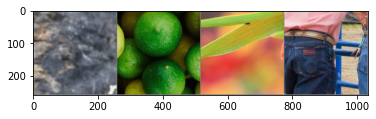

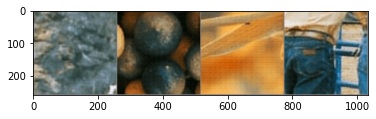

In [15]:
dataiter = iter(testloader)
images = dataiter.next()
outputs = model(images.to(device)).detach().cpu()
# show images
imshow(torchvision.utils.make_grid(images))
imshow(np.clip(torchvision.utils.make_grid(outputs), -1, 1))

## Demosaicking network